Some data was collected prior writing this report. For example,
`./data/sites_published` has the output `aws s3 ls` for the `publisherstore-us`
bucket that contains archives of the published websites. In addition,
`./data/sites_to_copy.csv` contains site ids that needs to be republished. At
the moment, SQL query for them looks like that:

```sql
select distinct sps.id
from sites_publishedsite sps
         join (select distinct published_site_id,
                               max(IF(ssr.store_id in (16, 17, 18, 19), 1, 0)) as has_new_stores
               from sites_sitereplicant ssr
               group by published_site_id
               having has_new_stores = 0) ssr
              on ssr.published_site_id = sps.id
where sps.state = 0
  and sps.disabled = 0
  and sps.date_published >= DATE '2018-08-01'
  and sps.canonical_host is not null
```

Let's prepare our data. We will select ZIP files from the bucket.


In [1]:
# !pv ./data/sites_published | grep .zip | \
# 	awk '{gsub(".zip$", "", $4);print $4}' > \
# 	./data/transformed/sites_published_zips.csv

Here is how look ids of the sites that we need to copy

In [2]:
import pandas as pd
# import modin.pandas as pd
sites_to_copy = pd.read_csv(
	'./data/sites_to_copy.csv',
	names=['site_to_copy_ids', 'site_publish_date'],
	parse_dates=['site_publish_date']
	).set_index('site_to_copy_ids')
sites_to_copy.head()

,site_publish_date
site_to_copy_ids,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00
00008a6f271548ff9a6274620c7bd6cc,2020-05-14 21:40:34+00:00
0000a6c1778a44d1a0687266a94f00a9,2019-01-23 17:21:25+00:00


There are plenty of them:

In [3]:
sites_to_copy.count()

site_publish_date    355811
dtype: int64

Here is how look ids of the artifacts in the S3

In [4]:
sites_published_zips = pd.read_csv(
	'./data/transformed/sites_published_zips.csv',
	names=['site_published_zips'])
sites_published_zips.head()

,site_published_zips
0,00001f94c5c54973b5539aca547f48cf
1,0000201ae82e4b1293c860235894200f
2,0000237a29ef4155a731cac18e3425a5
3,0000252074964f219d47ea136ffef019
4,00002f6e7c274081873af579c80e3a25


Is there any site without an archive?

In [5]:
set_sites_published_zips = set(
	sites_published_zips['site_published_zips'].values.tolist())
set_sites_to_copy = sites_to_copy.index.values.tolist()
diff_absent_archives = set(set_sites_to_copy).difference( set_sites_published_zips)


print(bool(diff_absent_archives))

True


Really? Give an example please.

In [6]:
import random
random.sample(diff_absent_archives, 10)

['939ed2fc8d4e478a9df6d802ef8d4997',
 '8401b548aa3d4dba82e6c3f2a2c58c26',
 '24cfda2ca6844ec3aca29d90a8d9a157',
 'e5e5d49073e94d80b9cc8c23dd256680',
 'ac6fb7611eb6469aa3905878adb12ace',
 '308d55902a654ece8967a42f3797dce0',
 '8abdab2d0cbc4187abcfdbf60ec1db5d',
 '1fcbfd1c5dcd4581abf5e8fd74057d08',
 '468def12a5ef451e98728243bc970d72',
 '51ba40c4e4224859b20e2dc7510c482d']

How many?

In [7]:
print('Total: %s' % len(diff_absent_archives))

Total: 10414


Ok, let's prepare our data, but this time we will include object
 creation date.

In [8]:
# !pv ./data/sites_published | grep .zip | \
# 	awk '{gsub(".zip$", "" ,$4); print $4 "," $1 "T" $2 "Z"}' > \
# 	./data/transformed/sites_published_zips_with_dates.csv

Archives and their creation dates(a-la CSV).

In [9]:
!head -n 5 ./data/transformed/sites_published_zips_with_dates.csv

00001f94c5c54973b5539aca547f48cf,2016-03-09T19:07:12Z
0000201ae82e4b1293c860235894200f,2020-10-05T06:02:05Z
0000237a29ef4155a731cac18e3425a5,2017-11-07T05:16:45Z
0000252074964f219d47ea136ffef019,2016-06-23T07:29:33Z
00002f6e7c274081873af579c80e3a25,2015-11-05T21:27:35Z


Sites and their publishing dates(CSV).

In [10]:
!head -n 5 ./data/sites_to_copy.csv

0000201ae82e4b1293c860235894200f,2020-10-05T06:02:04Z
00003b1c0f064827bdc7e0397139dc93,2019-05-26T06:45:48Z
000047159c254c06848660d03a72f038,2020-02-14T17:07:26Z
00008a6f271548ff9a6274620c7bd6cc,2020-05-14T21:40:34Z
0000a6c1778a44d1a0687266a94f00a9,2019-01-23T17:21:25Z


In [11]:
sites_published_zips_with_dates = pd.read_csv(
	'./data/transformed/sites_published_zips_with_dates.csv',
	names=['site_published_zips_ids', 's3_object_published_date'],
	parse_dates=['s3_object_published_date']
).set_index('site_published_zips_ids')

We can join sites and archives on id

In [12]:
dates_joined = sites_to_copy.join(
	sites_published_zips_with_dates, lsuffix='l_', rsuffix='r_')
dates_joined.head()

,site_publish_date,s3_object_published_date
site_to_copy_ids,,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00,2020-10-05 06:02:05+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00,2019-05-26 06:45:49+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00,2020-02-14 17:07:26+00:00
00008a6f271548ff9a6274620c7bd6cc,2020-05-14 21:40:34+00:00,2020-05-14 21:40:35+00:00
0000a6c1778a44d1a0687266a94f00a9,2019-01-23 17:21:25+00:00,2019-01-23 17:21:25+00:00


Let's calculate the timedelta between two publishing dates.

In [13]:
dates_joined['timedelta'] = (dates_joined['s3_object_published_date']
	- dates_joined['site_publish_date'])

In [14]:
dates_joined.sort_values('timedelta')

,site_publish_date,s3_object_published_date,timedelta
site_to_copy_ids,,,
8a49866b2966498601298fd5da6f26c9,2020-11-18 13:55:26+00:00,2010-09-04 21:18:15+00:00,-3728 days +07:22:49
8a49866b2a910c98012a96734c144cbe,2020-11-18 13:55:48+00:00,2010-09-09 17:10:09+00:00,-3723 days +03:14:21
8a49866a2af939b8012afaf34d3a118c,2020-11-18 13:43:41+00:00,2010-09-10 10:01:53+00:00,-3723 days +20:18:12
8a49866a2afe125c012b094dfba27d42,2020-11-11 12:41:20+00:00,2010-09-13 05:19:18+00:00,-3713 days +16:37:58
8a4986cb2b8aa1a7012b9b38f7121aa7,2020-11-18 13:56:03+00:00,2010-10-11 12:17:31+00:00,-3692 days +22:21:28
...,...,...,...
ffee42d6549a4a17b99e66e655361b27,2019-02-27 06:58:56+00:00,NaT,NaT
ffefac401f764344be62136a24762b2b,2019-03-21 17:56:01+00:00,NaT,NaT
fff25cfce17b4ef1944e9a5ffa7c158f,2019-03-25 20:49:20+00:00,NaT,NaT


In [15]:
no_na = dates_joined.sort_values('timedelta').dropna()
short_discrepancy = no_na[(no_na['timedelta'] > pd.Timedelta(days=1))
	  | (no_na['timedelta'] < pd.Timedelta(days=-1))]

How many sites have publishing date discrepancy with their S3 object?
Also, exclude sites that miss archive completely.

In [16]:
short_discrepancy.count()

site_publish_date           8227
s3_object_published_date    8227
timedelta                   8227
dtype: int64

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
discrepancy_dates = short_discrepancy.apply(
	lambda row: row.site_publish_date.date(), axis='columns')

In [19]:
discrepancy_dates.value_counts()

2020-11-18    570
2020-11-23    564
2020-11-20    527
2020-11-22    523
2020-11-19    486
             ... 
2020-03-19      1
2020-06-03      1
2020-03-15      1
2018-12-10      1
2019-06-09      1
Length: 78, dtype: int64

Show please when happened discrepancies between site publish data and S3 object
 creation timestamp.

<AxesSubplot:xlabel='Date', ylabel='Discrepancy Publish Count'>

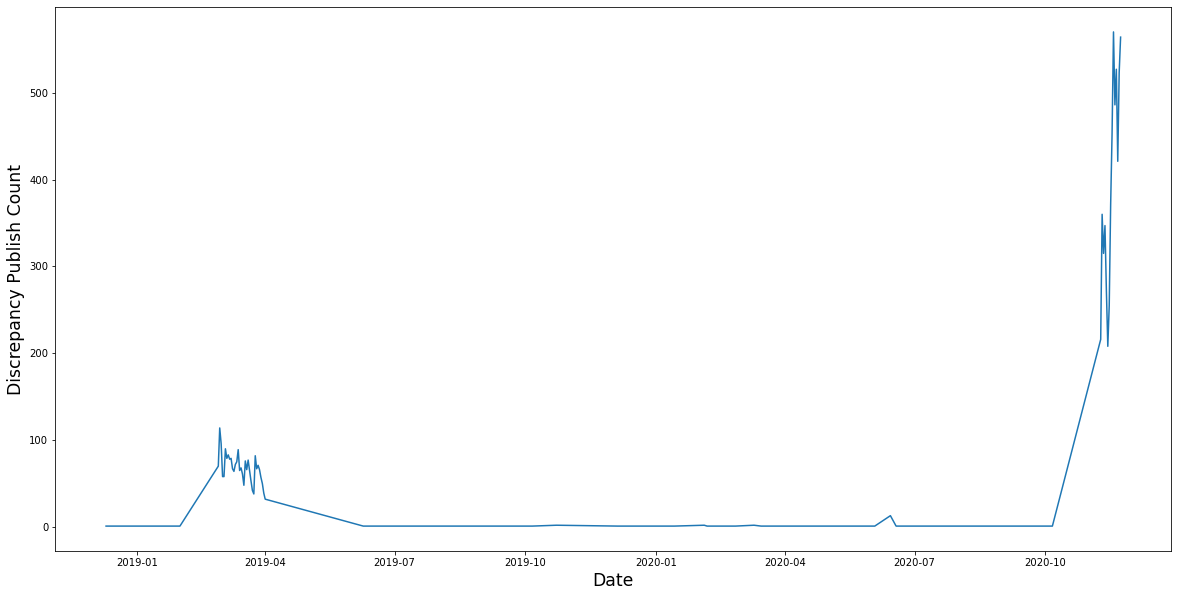

In [20]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Discrepancy Publish Count', **{'fontsize': 'xx-large'})
discrepancy_dates.value_counts().plot()

Now let's find more info about the absent artifacts. Show please the count of
 sites with absent artifacts per site publishing date.

In [21]:
absent_values = dates_joined[
	dates_joined['s3_object_published_date'].isna()
	& (dates_joined['site_publish_date'] < pd.Timestamp(
		'2020-11-01T00:00Z'))]
absent_dates = absent_values.apply(
	lambda row: row.site_publish_date.date(), axis='columns'
)
absent_dates.value_counts()
pass

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts'>

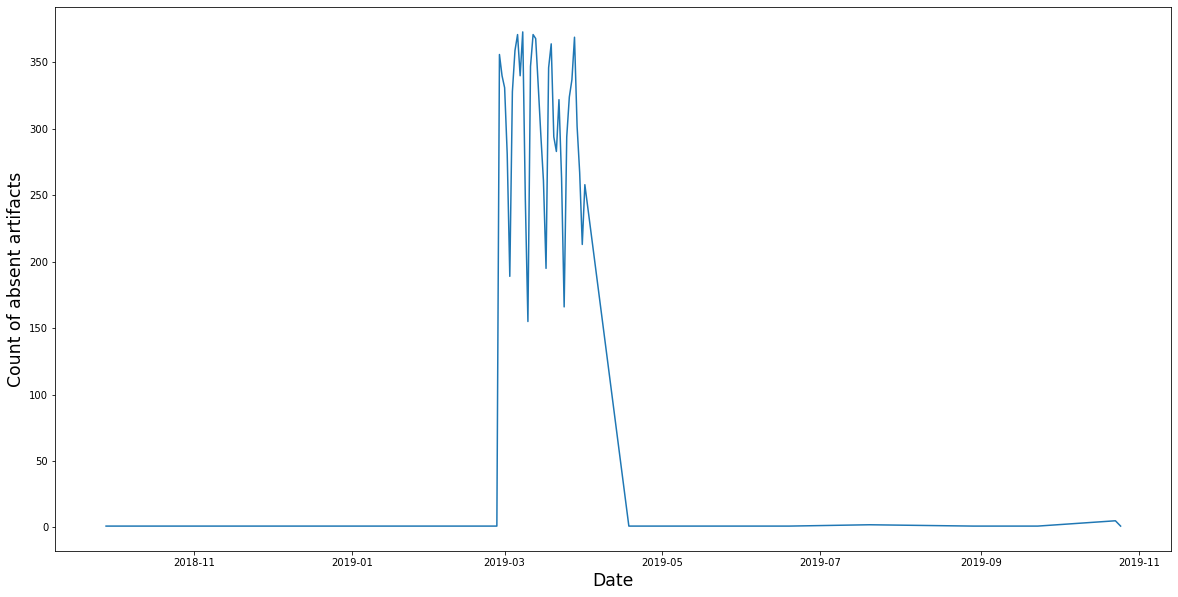

In [22]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

The same plot, but Y-axis log scale, please?

<AxesSubplot:xlabel='Date', ylabel='Count of absent artifacts, log scale'>

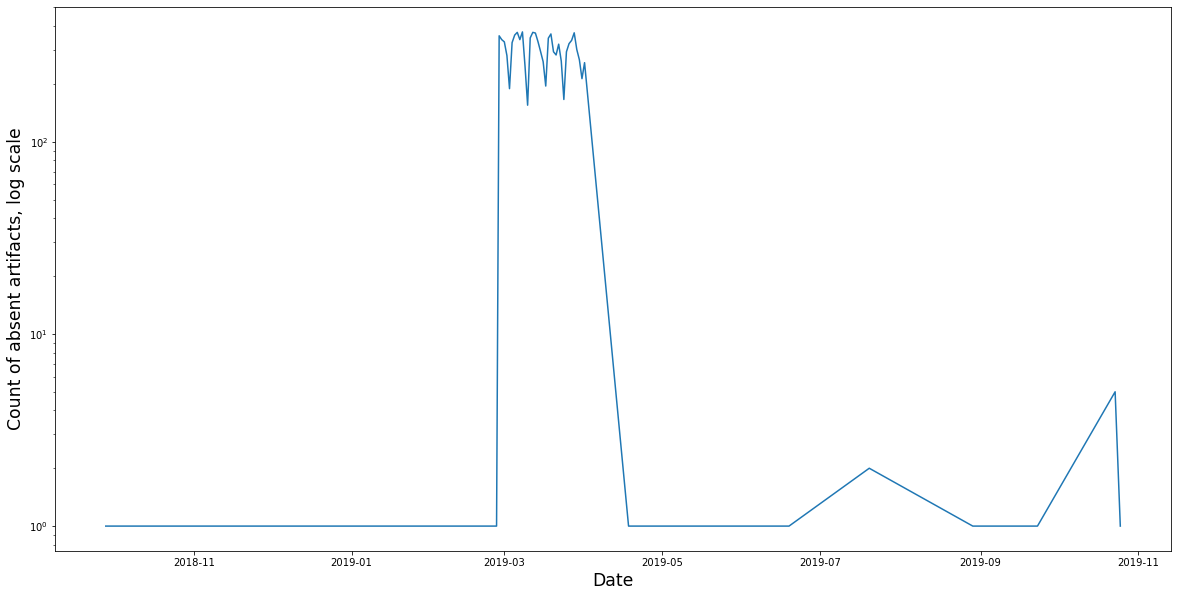

In [23]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.ylabel('Count of absent artifacts, log scale', **{'fontsize': 'xx-large'})
absent_dates.value_counts().plot()

By the way, how many artifacts are absent before we started the work
 on this ticket?

In [24]:
absent_values.count()

site_publish_date           10256
s3_object_published_date        0
timedelta                       0
dtype: int64

What if we dig deeper and check discrepancies in publishing for a longer period
 of time?

In [25]:
# !pv ./data/all_published_sites_and_their_dates.csv | \
# 	awk '{print $1 "T" $2 "Z"}' > \
# 	./data/transformed/all_published_sites_and_their_dates.csv

In [26]:
! head -n 5  ./data/transformed/all_published_sites_and_their_dates.csv

0000201ae82e4b1293c860235894200f,2020-10-05T06:02:04Z
0000237a29ef4155a731cac18e3425a5,2017-11-07T05:16:42Z
0000252074964f219d47ea136ffef019,2016-06-23T07:29:33Z
00003b1c0f064827bdc7e0397139dc93,2019-05-26T06:45:48Z
000047159c254c06848660d03a72f038,2020-02-14T17:07:26Z


In [27]:
all_sites_with_dates = pd.read_csv(
	'./data/transformed/all_published_sites_and_their_dates.csv',
	names=['site_id', 'site_published_date'],
	parse_dates=['site_published_date']
).set_index('site_id')


In [28]:
all_sites_with_dates.head()

,site_published_date
site_id,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00
0000237a29ef4155a731cac18e3425a5,2017-11-07 05:16:42+00:00
0000252074964f219d47ea136ffef019,2016-06-23 07:29:33+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00


In [29]:
all_sites_artifacts_joined = all_sites_with_dates.join(
	sites_published_zips_with_dates)
all_sites_artifacts_joined.head()

,site_published_date,s3_object_published_date
site_id,,
0000201ae82e4b1293c860235894200f,2020-10-05 06:02:04+00:00,2020-10-05 06:02:05+00:00
0000237a29ef4155a731cac18e3425a5,2017-11-07 05:16:42+00:00,2017-11-07 05:16:45+00:00
0000252074964f219d47ea136ffef019,2016-06-23 07:29:33+00:00,2016-06-23 07:29:33+00:00
00003b1c0f064827bdc7e0397139dc93,2019-05-26 06:45:48+00:00,2019-05-26 06:45:49+00:00
000047159c254c06848660d03a72f038,2020-02-14 17:07:26+00:00,2020-02-14 17:07:26+00:00


In [30]:
all_sites_artifacts_joined['timedelta'] = (
	all_sites_artifacts_joined['s3_object_published_date']
		- all_sites_artifacts_joined['site_published_date'])

In [31]:
all_sites_artifacts_joined.sort_values('timedelta')

,site_published_date,s3_object_published_date,timedelta
site_id,,,
8a49866b2966498601298fd5da6f26c9,2020-11-18 13:55:26+00:00,2010-09-04 21:18:15+00:00,-3728 days +07:22:49
8a49866b2a910c98012a96734c144cbe,2020-11-18 13:55:48+00:00,2010-09-09 17:10:09+00:00,-3723 days +03:14:21
8a49866a2af939b8012afaf34d3a118c,2020-11-18 13:43:41+00:00,2010-09-10 10:01:53+00:00,-3723 days +20:18:12
8a49866a2afe125c012b094dfba27d42,2020-11-11 12:41:20+00:00,2010-09-13 05:19:18+00:00,-3713 days +16:37:58
8a4986cb2b8aa1a7012b9b38f7121aa7,2020-11-18 13:56:03+00:00,2010-10-11 12:17:31+00:00,-3692 days +22:21:28
...,...,...,...
ffee42d6549a4a17b99e66e655361b27,2019-02-27 06:58:56+00:00,NaT,NaT
ffefac401f764344be62136a24762b2b,2019-03-21 17:56:01+00:00,NaT,NaT
fff25cfce17b4ef1944e9a5ffa7c158f,2019-03-25 20:49:20+00:00,NaT,NaT


In [32]:
all_no_na = all_sites_artifacts_joined.dropna()
all_discrepancies_dates = all_no_na[
	(all_no_na['timedelta'] > pd.Timedelta(days=1))
	  | (all_no_na['timedelta'] < pd.Timedelta(days=-1))]

In [33]:
import swifter  # noqa
# swifter.register_modin()
all_discrepancies_dates = all_discrepancies_dates.swifter.apply(
	lambda row: row.site_published_date.date(), axis='columns'
)
all_discrepancies_dates.head()

site_id
00007d414a464399a0981fd0681c5bcd    2015-03-29
00007df545da4f52ab49a453dc537250    2015-02-18
0000d400fc444267a54cf40bf089eafd    2015-03-28
0001ba217be84d49bf19714cc59c19d4    2015-03-26
0001ef9b14d14cc68830e90a70de25bb    2015-02-18
dtype: object

<AxesSubplot:xlabel='Date', ylabel='Discrepancy Publish Count, log scale'>

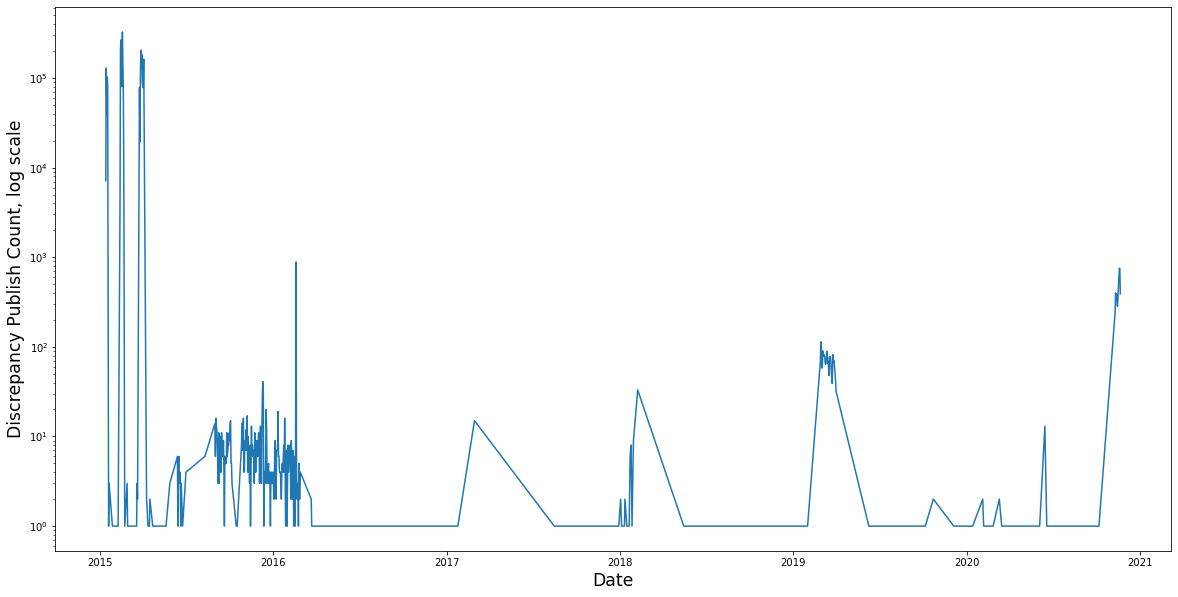

In [34]:
plt.figure(figsize=(20, 10))
plt.xlabel('Date', **{'fontsize': 'xx-large'})
plt.yscale('log')
plt.ylabel('Discrepancy Publish Count, log scale', **{'fontsize': 'xx-large'})
all_discrepancies_dates.value_counts().plot()

In [39]:
with open('./data/transformed/output_discrepancy.py', 'w') as f:
	f.write(str(set(short_discrepancy.index.tolist())))

In [42]:
with open('./data/transformed/output_absent_archives.py', 'w') as f:
	f.write(str(diff_absent_archives))
# list(diff_absent_archives)[:10]

In [43]:
short_discrepancy.count()

site_publish_date           8227
s3_object_published_date    8227
timedelta                   8227
dtype: int64

In [44]:
len(diff_absent_archives)

10414